### **Imports and configs**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
# from pytorch_pretrained_vit import ViT
from vit_pytorch import ViT
from vit_pytorch.deepvit import DeepViT
 
from torchsummary import summary

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tqdm import tqdm
import sys
from PIL import Image
import numpy as np

### **Util functions for preparing data, training/validating/testing the model, and displaying results**

#### *Data preprocessing/preparation*

In [2]:
class DataAugmentation(Dataset):
    """  
    A class for applying some transform (augmentation) to an image.
    """

    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform


    def __getitem__(self, index):
        image, label = self.dataset[index]
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label


    def __len__(self):
        return len(self.dataset) 
        

def split_dataset(dataset_path, resize_shape=(64, 64)):
    """  
    Function to split the dataset into 80-10-10 ratio and return those splitted datasets.
    """

    initial_transform = transforms.Compose(
        [
            transforms.Resize(resize_shape),
            transforms.ToTensor()
        ]
    )

    dataset = ImageFolder(root=dataset_path, transform=initial_transform)
    dataset_size = len(dataset)
    dataset_classes = dataset.classes

    print(f'Total length of the dataset = {dataset_size}')
    print(f'Total classes of the dataset = {dataset_classes}')
    

    train_size = int(0.8 * dataset_size) # Taking 80% of total data as the train_size. 
    val_test_size = dataset_size - train_size # This size is for val-test. We will split it into val-test below.
    
    # Now, we will take the remaining 20% of the dataset as a 10-10 ratio for val_size and test_size. 
    val_size = int(0.5 * val_test_size) 
    test_size = val_test_size - val_size
    
    train_dataset, val_test_dataset = random_split(dataset, [train_size, val_test_size]) # Splitting into 80-20 ratio.
    val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size]) # Splitting into 10-10 ratio.

    print(f'80-10-10 split ratio count:')
    print(f'Train data = {len(train_dataset)} | Validation data = {len(val_dataset)} | Test data = {len(test_dataset)}\n')

    return [train_dataset, val_dataset, test_dataset]


def get_mean_std(dataset, batch_size=16):
    """
    Function to get mean and std (channel-wise) of images contained in a dataset and return the mean & std.
    We usually use this function for train_dataset. But it can be used for any dataset.
    """

    data_loader = DataLoader(dataset=dataset, batch_size=batch_size)

    mean = 0.0
    std = 0.0
    for images, _ in tqdm(data_loader):
        n_images_in_batch = images.size(0) #[batch_size, channels, h, w]
        images = images.view(n_images_in_batch, images.size(1), -1) # [batch_size, channels, h*w]
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(data_loader.dataset)
    std /= len(data_loader.dataset)
    return mean, std


def apply_data_augmentation(train_dataset, val_dataset, test_dataset, mean, std, resize_shape=(64, 64)):
    """  
    Function to apply data augmentation and return the datasets which are normalized and augmented. 
    """

    train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(resize_shape),
            transforms.RandomRotation(degrees=180),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
    
    val_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(resize_shape),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
    
    test_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(resize_shape),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

    train_dataset_normalized_augmented = DataAugmentation(dataset=train_dataset, transform=train_transform)
    val_dataset_normalized_augmented = DataAugmentation(dataset=val_dataset, transform=val_transform)
    test_dataset_normalized_augmented = DataAugmentation(dataset=test_dataset, transform=test_transform)

    return [train_dataset_normalized_augmented, val_dataset_normalized_augmented, test_dataset_normalized_augmented]


def prepare_data(dataset_path, batch_size=16, resize_shape=(64, 64)):
    """ 
    Function to prepare the dataset and return train-val-test data loaders.

    1. First, it splits the dataset into train-val-test in the ratio of 80-10-10. 
    2. Second, it calculates the mean and std of train_dataset.
    3. Third, we apply data augmentation to train-val-test datasets. 
    4. Last, we setup data loaders for train-val-test with a fixed batch_size.
    """

    # Step 1
    train_dataset, val_dataset, test_dataset = split_dataset(dataset_path=dataset_path, resize_shape=resize_shape)

    #Step 2 
    print('Extracting mean and std...')
    mean, std = get_mean_std(dataset=train_dataset, batch_size=batch_size)
    print(f'Mean = {mean} | Std = {std}\n')

    #Step 3 
    print(f'Augmenting the data.\n')
    train_dataset_normalized_augmented, val_dataset_normalized_augmented, test_dataset_normalized_augmented = apply_data_augmentation(
        train_dataset=train_dataset, 
        val_dataset=val_dataset, 
        test_dataset=test_dataset, 
        mean=mean, 
        std=std,
        resize_shape=resize_shape
    )
    
    #Step 4 
    print('Returning train-val-test loaders.')
    train_loader = DataLoader(dataset=train_dataset_normalized_augmented, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset_normalized_augmented, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset_normalized_augmented, batch_size=batch_size, shuffle=True)

    return [train_loader, val_loader, test_loader]

#### *Training/validating/testing the model*

In [3]:
def train(model, train_loader, loss_fn, optimizer, scheduler, curr_epoch, total_epochs, device):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    prog_bar = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    for batch_idx, (x, y) in prog_bar:   
        optimizer.zero_grad()   
        x, y = x.to(device), y.long().to(device)
       
        ypred = model(x)
        
        loss = loss_fn(ypred, y) 
        
        running_loss += loss.item()
        _, predicted = torch.max(ypred, 1)
        total_predictions += y.size(0)
        correct_predictions += (predicted == y).sum().item()

        loss.backward()
        optimizer.step()
        
        prog_bar.set_description(f'Epoch {curr_epoch}/{total_epochs}')
     
    running_loss /= len(train_loader)
    scheduler.step(running_loss)
    acc = 100.0*correct_predictions/total_predictions

    return running_loss, acc


def validate(model, val_loader, loss_fn, device):
    with torch.no_grad():
        model.eval()
        
        running_loss = 0.0
        total_predictions = 0
        correct_predictions = 0

        for batch_idx, (x, y) in enumerate(val_loader):   
            x, y = x.to(device), y.long().to(device)

            ypred = model(x)

            _, predicted = torch.max(ypred, 1)
            total_predictions += y.size(0)
            correct_predictions += (predicted == y).sum().item()

            loss = loss_fn(ypred, y)
            running_loss += loss.item()

    running_loss /= len(val_loader)
    acc = 100.0*correct_predictions/total_predictions

    return running_loss, acc


def get_test_results(model, test_loader, labels, device):
    predicted_ys = torch.tensor([]).to(device)
    true_ys = torch.tensor([]).to(device)

    with torch.no_grad():
        model.eval()

        total_predictions = 0
        correct_predictions = 0

        for batch_idx, (x, y) in tqdm(enumerate(test_loader)):
            x, y = x.to(device), y.long().to(device)

            ypred = model(x)

            _, predicted = torch.max(ypred, 1)
            total_predictions += y.size(0)
            correct_predictions += (predicted == y).sum().item()

            true_ys = torch.cat((true_ys, y))
            predicted_ys = torch.cat((predicted_ys, predicted))
            
    acc = 100.0*correct_predictions/total_predictions

    true_ys = true_ys.detach().cpu().numpy()
    predicted_ys = predicted_ys.detach().cpu().numpy()

    cm = confusion_matrix(true_ys, predicted_ys)
    rep = classification_report(true_ys, predicted_ys, target_names=labels, output_dict=True)
    df_rep = pd.DataFrame.from_dict(rep).transpose()
    
    return [acc, cm, df_rep]

#### *Displaying results*

In [4]:
def plot_acc_loss(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(8, 6)) 
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train','Val'])
    plt.title('Train/Val Accuracy Vs Epoch')
    plt.show()
    
    plt.figure(figsize=(8,6)) 
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Val'])
    plt.title('Train/Val Loss Vs Epoch')
    plt.show()


def plot_conf_mat(confusion_matrix, labels):
    index = labels  
    columns = labels  
    cm_df = pd.DataFrame(confusion_matrix, columns, index)                      
    plt.figure(figsize=(11,7)) 
    plt.xticks(rotation=90)
    sn.heatmap(cm_df, annot=True, cmap="Blues")

    plt.title('Confusion Matrix (Test Data)') 
    plt.xlabel('Predicted') 
    plt.ylabel('True')
    plt.show()

#### *Fit and run the model*

In [5]:
def run_model(model, model_name, optim, scheduler, labels, train_loader, val_loader, test_loader, epochs=2, device='cpu', plot_graphs=False):

    model.to(device)

    print(f'DEVICE: {device}\n')
    
    loss_fn = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    best_val_acc = -sys.maxsize

    print('='*100)

    for epoch in range(1, epochs+1):
        tr_loss, tr_acc = train(model, train_loader, loss_fn, optim, scheduler, epoch, epochs, device)
        val_loss, val_acc = validate(model, val_loader, loss_fn, device)

        train_losses.append(tr_loss)
        val_losses.append(val_loss)
        train_accs.append(tr_acc)
        val_accs.append(val_acc)

        print(f'train_loss = {tr_loss:.4f} | val_loss = {val_loss:.4f} | train_acc = {tr_acc:.4f}% | val_acc = {val_acc:.4f}%')
        
        # Saving the model parameters if val_acc improves.
        if val_acc >= best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'{model_name}_parameters.pt')  
            print(f'val_acc improved -> saving model parameters to -> "{model_name}_parameters.pt"')
            
        print('='*100)

    print('\n')

    print('*'*100)
    print('Running the model on test set:\n')
    
    print(f'Loading the best model from -> "{model_name}_parameters.pt"')
    model.load_state_dict(torch.load(f'{model_name}_parameters.pt'))

    test_acc, cm, classif_rep = get_test_results(model, test_loader, labels, device)
    
    print(f'Test acc = {test_acc:.6f}%\n')
    print('Classification report:\n')
    print(classif_rep)
    print('\n')

    if plot_graphs:
        print('Graphs:\n')
        plot_acc_loss(train_losses, val_losses, train_accs, val_accs)
        plot_conf_mat(cm, labels)
    
    print('*'*100)

### **Models**

##### *Normalized CNN*

In [13]:
class NormalizedCNNModel(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=131072, out_features=1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1024, out_features=num_classes)
        )
    
    def forward(self, x):
        x = self.net(x)
        return x


summary(NormalizedCNNModel(num_classes=7).cuda(), input_size=(3, 128, 128), batch_size=8, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 32, 128, 128]             896
       BatchNorm2d-2          [8, 32, 128, 128]              64
              ReLU-3          [8, 32, 128, 128]               0
            Conv2d-4          [8, 64, 128, 128]          18,496
       BatchNorm2d-5          [8, 64, 128, 128]             128
              ReLU-6          [8, 64, 128, 128]               0
         MaxPool2d-7            [8, 64, 64, 64]               0
            Conv2d-8           [8, 128, 64, 64]          73,856
       BatchNorm2d-9           [8, 128, 64, 64]             256
             ReLU-10           [8, 128, 64, 64]               0
           Conv2d-11           [8, 128, 64, 64]         147,584
      BatchNorm2d-12           [8, 128, 64, 64]             256
             ReLU-13           [8, 128, 64, 64]               0
        MaxPool2d-14           [8, 128,

Total length of the dataset = 3737
Total classes of the dataset = ['dew', 'hail', 'lightning', 'rain', 'rainbow', 'sandstorm', 'snow']
80-10-10 split ratio count:
Train data = 2989 | Validation data = 374 | Test data = 374

Extracting mean and std...


100%|██████████| 374/374 [00:10<00:00, 35.36it/s]


Mean = tensor([0.4977, 0.4983, 0.4459]) | Std = tensor([0.1849, 0.1804, 0.1897])

Augmenting the data.

Returning train-val-test loaders.
DEVICE: cuda



Epoch 1/25: 100%|██████████| 374/374 [00:34<00:00, 10.83it/s]


train_loss = 12.2014 | val_loss = 1.4119 | train_acc = 36.3667% | val_acc = 55.0802%
val_acc improved -> saving model parameters to -> "fm_model_parameters.pt"


Epoch 2/25: 100%|██████████| 374/374 [00:34<00:00, 10.80it/s]


train_loss = 1.5192 | val_loss = 1.4626 | train_acc = 43.9277% | val_acc = 55.3476%
val_acc improved -> saving model parameters to -> "fm_model_parameters.pt"


Epoch 3/25: 100%|██████████| 374/374 [00:34<00:00, 10.79it/s]


train_loss = 1.4732 | val_loss = 1.3999 | train_acc = 46.1693% | val_acc = 51.6043%


Epoch 4/25: 100%|██████████| 374/374 [00:34<00:00, 10.75it/s]


train_loss = 1.4285 | val_loss = 1.2933 | train_acc = 47.4406% | val_acc = 59.6257%
val_acc improved -> saving model parameters to -> "fm_model_parameters.pt"


Epoch 5/25: 100%|██████████| 374/374 [00:34<00:00, 10.72it/s]


train_loss = 1.3916 | val_loss = 1.2112 | train_acc = 48.5447% | val_acc = 60.4278%
val_acc improved -> saving model parameters to -> "fm_model_parameters.pt"


Epoch 6/25: 100%|██████████| 374/374 [00:34<00:00, 10.73it/s]


train_loss = 1.4081 | val_loss = 1.2869 | train_acc = 50.2844% | val_acc = 50.8021%


Epoch 7/25: 100%|██████████| 374/374 [00:34<00:00, 10.72it/s]


train_loss = 1.3765 | val_loss = 1.3549 | train_acc = 48.9796% | val_acc = 50.8021%


Epoch 8/25: 100%|██████████| 374/374 [00:34<00:00, 10.71it/s]


train_loss = 1.4300 | val_loss = 1.3015 | train_acc = 47.2064% | val_acc = 49.7326%


Epoch 9/25: 100%|██████████| 374/374 [00:34<00:00, 10.72it/s]


train_loss = 1.4788 | val_loss = 1.2321 | train_acc = 43.6935% | val_acc = 58.8235%


Epoch 10/25: 100%|██████████| 374/374 [00:34<00:00, 10.71it/s]


train_loss = 1.4406 | val_loss = 1.1917 | train_acc = 45.7009% | val_acc = 60.1604%


Epoch 11/25: 100%|██████████| 374/374 [00:34<00:00, 10.70it/s]


train_loss = 1.4441 | val_loss = 1.2240 | train_acc = 47.5744% | val_acc = 58.5561%


Epoch 12/25: 100%|██████████| 374/374 [00:34<00:00, 10.69it/s]


train_loss = 1.3584 | val_loss = 1.2451 | train_acc = 47.8421% | val_acc = 66.3102%
val_acc improved -> saving model parameters to -> "fm_model_parameters.pt"


Epoch 13/25: 100%|██████████| 374/374 [00:35<00:00, 10.68it/s]


train_loss = 1.2912 | val_loss = 1.1488 | train_acc = 51.8568% | val_acc = 59.0909%


Epoch 14/25: 100%|██████████| 374/374 [00:34<00:00, 10.70it/s]


train_loss = 1.2620 | val_loss = 1.0479 | train_acc = 53.6634% | val_acc = 67.9144%
val_acc improved -> saving model parameters to -> "fm_model_parameters.pt"


Epoch 15/25: 100%|██████████| 374/374 [00:35<00:00, 10.68it/s]


train_loss = 1.1649 | val_loss = 0.9748 | train_acc = 57.4105% | val_acc = 65.7754%


Epoch 16/25: 100%|██████████| 374/374 [00:35<00:00, 10.67it/s]


train_loss = 1.1797 | val_loss = 0.9866 | train_acc = 56.2395% | val_acc = 65.5080%


Epoch 17/25: 100%|██████████| 374/374 [00:35<00:00, 10.68it/s]


train_loss = 1.0976 | val_loss = 0.9719 | train_acc = 58.8157% | val_acc = 68.9840%
val_acc improved -> saving model parameters to -> "fm_model_parameters.pt"


Epoch 18/25: 100%|██████████| 374/374 [00:35<00:00, 10.68it/s]


train_loss = 1.0725 | val_loss = 1.0328 | train_acc = 61.6260% | val_acc = 66.0428%


Epoch 19/25: 100%|██████████| 374/374 [00:35<00:00, 10.67it/s]


train_loss = 1.0478 | val_loss = 0.9604 | train_acc = 61.3249% | val_acc = 64.4385%


Epoch 20/25: 100%|██████████| 374/374 [00:35<00:00, 10.68it/s]


train_loss = 1.0093 | val_loss = 0.9692 | train_acc = 62.7969% | val_acc = 68.7166%


Epoch 21/25: 100%|██████████| 374/374 [00:34<00:00, 10.69it/s]


train_loss = 0.9594 | val_loss = 0.9172 | train_acc = 66.1760% | val_acc = 69.2513%
val_acc improved -> saving model parameters to -> "fm_model_parameters.pt"


Epoch 22/25: 100%|██████████| 374/374 [00:35<00:00, 10.67it/s]


train_loss = 0.9106 | val_loss = 0.8849 | train_acc = 66.5440% | val_acc = 70.8556%
val_acc improved -> saving model parameters to -> "fm_model_parameters.pt"


Epoch 23/25: 100%|██████████| 374/374 [00:35<00:00, 10.67it/s]


train_loss = 0.9133 | val_loss = 0.8568 | train_acc = 66.6109% | val_acc = 69.5187%


Epoch 24/25: 100%|██████████| 374/374 [00:35<00:00, 10.67it/s]


train_loss = 0.9151 | val_loss = 0.8486 | train_acc = 66.6778% | val_acc = 70.0535%


Epoch 25/25: 100%|██████████| 374/374 [00:35<00:00, 10.68it/s]


train_loss = 0.8950 | val_loss = 0.8341 | train_acc = 68.2837% | val_acc = 69.2513%


****************************************************************************************************
Running the model on test set:

Loading the best model from -> "fm_model_parameters.pt"


47it [00:02, 18.52it/s]

Test acc = 77.540107%

Classification report:

              precision    recall  f1-score     support
dew            0.909091  0.895522  0.902256   67.000000
hail           0.836364  0.696970  0.760331   66.000000
lightning      0.850000  0.871795  0.860759   39.000000
rain           0.491228  0.538462  0.513761   52.000000
rainbow        0.562500  0.409091  0.473684   22.000000
sandstorm      0.927536  0.927536  0.927536   69.000000
snow           0.690141  0.830508  0.753846   59.000000
accuracy       0.775401  0.775401  0.775401    0.775401
macro avg      0.752409  0.738555  0.741739  374.000000
weighted avg   0.780471  0.775401  0.774909  374.000000


Graphs:



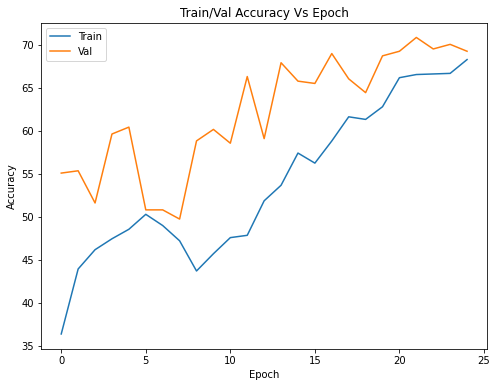

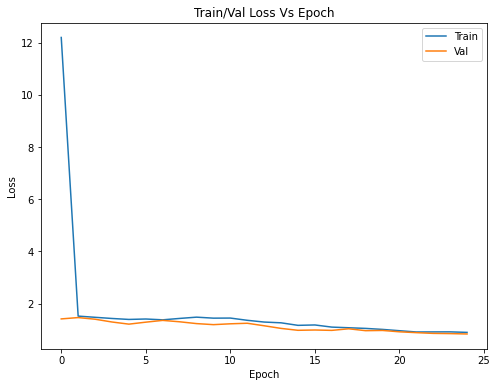

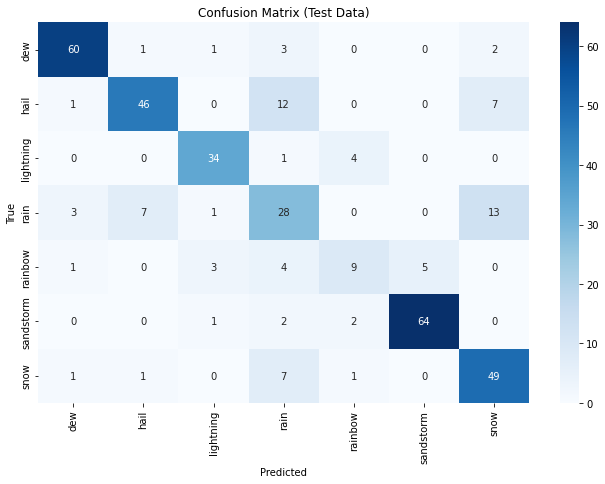

****************************************************************************************************


In [9]:
LABELS = ['dew', 'hail', 'lightning', 'rain', 'rainbow', 'sandstorm', 'snow']


train_loader, val_loader, test_loader = prepare_data(dataset_path='dataset', batch_size=8, resize_shape=(128, 128))


normalized_cnn_model = NormalizedCNNModel(num_classes=7)
optimizer = optim.Adam(normalized_cnn_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.01, patience=5, verbose=True)


run_model(model=normalized_cnn_model, model_name='normalized_cnn_model', optim=optimizer, scheduler=scheduler, labels=LABELS,
              train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
              epochs=25, device='cuda', plot_graphs=True)

##### *Resnet50*

In [14]:
class Resnet50TL(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.resnet50 = torchvision.models.resnet50(pretrained=True)
        self.fine_tune()
    

    def fine_tune(self):
        for param in self.resnet50.parameters():
            param.requires_grad = False
        
        self.resnet50.fc = nn.Sequential(
            nn.Linear(in_features=2048, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=self.num_classes)
        )
    

    def forward(self, x):
        x = self.resnet50(x)
        return x


summary(Resnet50TL(num_classes=7).cuda(), input_size=(3, 128, 128), batch_size=8, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [8, 64, 64, 64]           9,408
       BatchNorm2d-2            [8, 64, 64, 64]             128
              ReLU-3            [8, 64, 64, 64]               0
         MaxPool2d-4            [8, 64, 32, 32]               0
            Conv2d-5            [8, 64, 32, 32]           4,096
       BatchNorm2d-6            [8, 64, 32, 32]             128
              ReLU-7            [8, 64, 32, 32]               0
            Conv2d-8            [8, 64, 32, 32]          36,864
       BatchNorm2d-9            [8, 64, 32, 32]             128
             ReLU-10            [8, 64, 32, 32]               0
           Conv2d-11           [8, 256, 32, 32]          16,384
      BatchNorm2d-12           [8, 256, 32, 32]             512
           Conv2d-13           [8, 256, 32, 32]          16,384
      BatchNorm2d-14           [8, 256,

Total length of the dataset = 3737
Total classes of the dataset = ['dew', 'hail', 'lightning', 'rain', 'rainbow', 'sandstorm', 'snow']
80-10-10 split ratio count:
Train data = 2989 | Validation data = 374 | Test data = 374

Extracting mean and std...


100%|██████████| 374/374 [00:10<00:00, 34.45it/s]


Mean = tensor([0.4987, 0.4973, 0.4463]) | Std = tensor([0.1854, 0.1808, 0.1903])

Augmenting the data.

Returning train-val-test loaders.
DEVICE: cuda



Epoch 1/25: 100%|██████████| 374/374 [00:19<00:00, 19.46it/s]


train_loss = 0.8910 | val_loss = 0.9424 | train_acc = 68.9528% | val_acc = 66.8449%
val_acc improved -> saving model parameters to -> "resnet50_model_parameters.pt"


Epoch 2/25: 100%|██████████| 374/374 [00:18<00:00, 19.70it/s]


train_loss = 0.6698 | val_loss = 0.7045 | train_acc = 76.6812% | val_acc = 77.5401%
val_acc improved -> saving model parameters to -> "resnet50_model_parameters.pt"


Epoch 3/25: 100%|██████████| 374/374 [00:19<00:00, 19.42it/s]


train_loss = 0.6037 | val_loss = 0.5871 | train_acc = 79.2573% | val_acc = 78.6096%
val_acc improved -> saving model parameters to -> "resnet50_model_parameters.pt"


Epoch 4/25: 100%|██████████| 374/374 [00:19<00:00, 19.31it/s]


train_loss = 0.6061 | val_loss = 0.6269 | train_acc = 78.1532% | val_acc = 78.0749%


Epoch 5/25: 100%|██████████| 374/374 [00:19<00:00, 19.31it/s]


train_loss = 0.6012 | val_loss = 0.5787 | train_acc = 78.7889% | val_acc = 79.9465%
val_acc improved -> saving model parameters to -> "resnet50_model_parameters.pt"


Epoch 6/25: 100%|██████████| 374/374 [00:20<00:00, 18.60it/s]


train_loss = 0.5684 | val_loss = 0.5077 | train_acc = 80.0268% | val_acc = 80.2139%
val_acc improved -> saving model parameters to -> "resnet50_model_parameters.pt"


Epoch 7/25: 100%|██████████| 374/374 [00:20<00:00, 18.55it/s]


train_loss = 0.5315 | val_loss = 0.4915 | train_acc = 81.5323% | val_acc = 82.8877%
val_acc improved -> saving model parameters to -> "resnet50_model_parameters.pt"


Epoch 8/25: 100%|██████████| 374/374 [00:20<00:00, 18.56it/s]


train_loss = 0.5392 | val_loss = 0.7057 | train_acc = 81.4988% | val_acc = 76.7380%


Epoch 9/25: 100%|██████████| 374/374 [00:20<00:00, 18.56it/s]


train_loss = 0.5321 | val_loss = 0.5695 | train_acc = 82.0007% | val_acc = 82.6203%


Epoch 10/25: 100%|██████████| 374/374 [00:19<00:00, 18.78it/s]


train_loss = 0.5156 | val_loss = 0.5133 | train_acc = 81.2646% | val_acc = 83.6898%
val_acc improved -> saving model parameters to -> "resnet50_model_parameters.pt"


Epoch 11/25: 100%|██████████| 374/374 [00:20<00:00, 18.22it/s]


train_loss = 0.5104 | val_loss = 0.5483 | train_acc = 82.1679% | val_acc = 82.0856%


Epoch 12/25: 100%|██████████| 374/374 [00:19<00:00, 18.92it/s]


train_loss = 0.4929 | val_loss = 0.4398 | train_acc = 82.2349% | val_acc = 84.7594%
val_acc improved -> saving model parameters to -> "resnet50_model_parameters.pt"


Epoch 13/25: 100%|██████████| 374/374 [00:19<00:00, 18.80it/s]


train_loss = 0.4620 | val_loss = 0.4961 | train_acc = 84.0749% | val_acc = 82.8877%


Epoch 14/25: 100%|██████████| 374/374 [00:20<00:00, 18.32it/s]


train_loss = 0.5021 | val_loss = 0.4454 | train_acc = 81.9003% | val_acc = 84.2246%


Epoch 15/25: 100%|██████████| 374/374 [00:20<00:00, 18.52it/s]


train_loss = 0.4801 | val_loss = 0.6170 | train_acc = 83.7069% | val_acc = 77.8075%


Epoch 16/25: 100%|██████████| 374/374 [00:20<00:00, 18.57it/s]


train_loss = 0.4682 | val_loss = 0.4248 | train_acc = 83.6400% | val_acc = 85.2941%
val_acc improved -> saving model parameters to -> "resnet50_model_parameters.pt"


Epoch 17/25: 100%|██████████| 374/374 [00:20<00:00, 18.25it/s]


train_loss = 0.4617 | val_loss = 0.4446 | train_acc = 84.0080% | val_acc = 84.7594%


Epoch 18/25: 100%|██████████| 374/374 [00:20<00:00, 18.32it/s]


train_loss = 0.4704 | val_loss = 0.3886 | train_acc = 82.7367% | val_acc = 85.2941%
val_acc improved -> saving model parameters to -> "resnet50_model_parameters.pt"


Epoch 19/25: 100%|██████████| 374/374 [00:20<00:00, 18.33it/s]


train_loss = 0.4518 | val_loss = 0.3851 | train_acc = 84.5768% | val_acc = 85.2941%
val_acc improved -> saving model parameters to -> "resnet50_model_parameters.pt"


Epoch 20/25: 100%|██████████| 374/374 [00:20<00:00, 18.57it/s]


train_loss = 0.4548 | val_loss = 0.4592 | train_acc = 84.0415% | val_acc = 83.6898%


Epoch 21/25: 100%|██████████| 374/374 [00:20<00:00, 18.23it/s]


train_loss = 0.4290 | val_loss = 0.3989 | train_acc = 84.6771% | val_acc = 85.5615%
val_acc improved -> saving model parameters to -> "resnet50_model_parameters.pt"


Epoch 22/25: 100%|██████████| 374/374 [00:20<00:00, 18.45it/s]


train_loss = 0.4580 | val_loss = 0.4616 | train_acc = 83.8407% | val_acc = 83.1551%


Epoch 23/25: 100%|██████████| 374/374 [00:20<00:00, 18.37it/s]


train_loss = 0.4478 | val_loss = 0.4417 | train_acc = 83.4727% | val_acc = 83.4225%


Epoch 24/25: 100%|██████████| 374/374 [00:20<00:00, 18.32it/s]


train_loss = 0.4396 | val_loss = 0.4954 | train_acc = 84.7106% | val_acc = 83.4225%


Epoch 25/25: 100%|██████████| 374/374 [00:20<00:00, 18.68it/s]


train_loss = 0.4266 | val_loss = 0.3906 | train_acc = 85.1455% | val_acc = 86.0963%
val_acc improved -> saving model parameters to -> "resnet50_model_parameters.pt"


****************************************************************************************************
Running the model on test set:

Loading the best model from -> "resnet50_model_parameters.pt"


47it [00:02, 19.34it/s]


Test acc = 88.770053%

Classification report:

              precision    recall  f1-score     support
dew            0.835821  0.982456  0.903226   57.000000
hail           0.942029  0.855263  0.896552   76.000000
lightning      0.971429  0.918919  0.944444   37.000000
rain           0.785714  0.825000  0.804878   40.000000
rainbow        1.000000  0.761905  0.864865   21.000000
sandstorm      0.920000  0.932432  0.926174   74.000000
snow           0.842857  0.855072  0.848921   69.000000
accuracy       0.887701  0.887701  0.887701    0.887701
macro avg      0.899693  0.875864  0.884151  374.000000
weighted avg   0.892633  0.887701  0.887797  374.000000


Graphs:



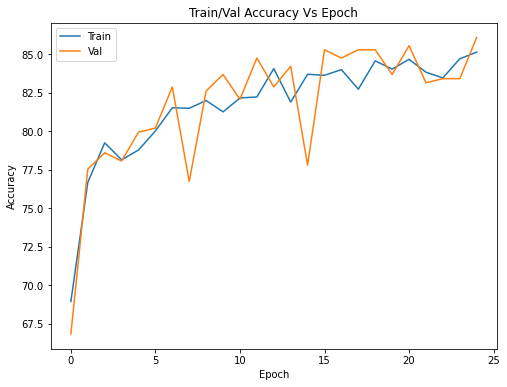

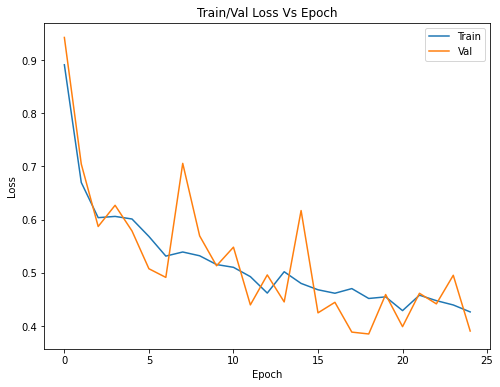

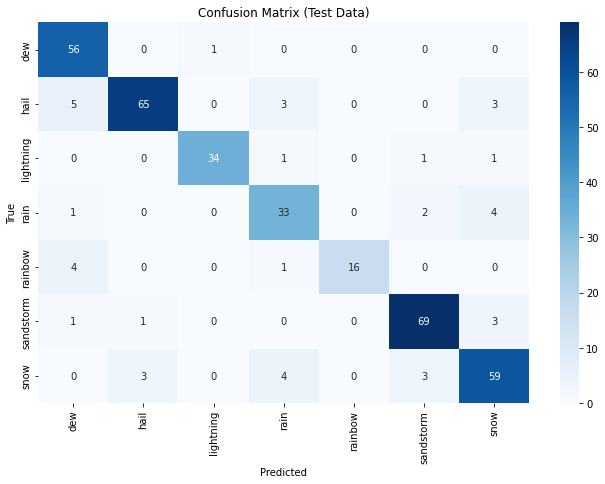

****************************************************************************************************


In [9]:
LABELS = ['dew', 'hail', 'lightning', 'rain', 'rainbow', 'sandstorm', 'snow']


train_loader, val_loader, test_loader = prepare_data(dataset_path='dataset', batch_size=8, resize_shape=(128, 128))


resnet50_model = Resnet50TL(num_classes=7)
optimizer = optim.Adam(resnet50_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.01, patience=5, verbose=True)


run_model(model=resnet50_model, model_name='resnet50_model', optim=optimizer, scheduler=scheduler, labels=LABELS,
              train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
              epochs=25, device='cuda', plot_graphs=True)

##### *Mobilenet V2*

In [15]:
class MobilenetTL(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.mn = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
        self.fine_tune()
    

    def fine_tune(self):
        for param in self.mn.parameters():
            param.requires_grad = False
        
        self.mn.classifier = nn.Sequential(
            nn.Dropout(0.2, inplace=False),
            nn.Linear(in_features=1280, out_features=512),
            nn.ReLU(), 
            nn.Linear(in_features=512, out_features=512), 
            nn.ReLU(), 
            nn.Linear(in_features=512, out_features=self.num_classes)
        )


    def forward(self, x):
        x = self.mn(x)
        return x


summary(MobilenetTL(num_classes=7).cuda(), input_size=(3, 128, 128), batch_size=8, device='cuda')

Using cache found in C:\Users\amaan/.cache\torch\hub\pytorch_vision_v0.10.0


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [8, 32, 64, 64]             864
       BatchNorm2d-2            [8, 32, 64, 64]              64
             ReLU6-3            [8, 32, 64, 64]               0
            Conv2d-4            [8, 32, 64, 64]             288
       BatchNorm2d-5            [8, 32, 64, 64]              64
             ReLU6-6            [8, 32, 64, 64]               0
            Conv2d-7            [8, 16, 64, 64]             512
       BatchNorm2d-8            [8, 16, 64, 64]              32
  InvertedResidual-9            [8, 16, 64, 64]               0
           Conv2d-10            [8, 96, 64, 64]           1,536
      BatchNorm2d-11            [8, 96, 64, 64]             192
            ReLU6-12            [8, 96, 64, 64]               0
           Conv2d-13            [8, 96, 32, 32]             864
      BatchNorm2d-14            [8, 96,

Total length of the dataset = 3737
Total classes of the dataset = ['dew', 'hail', 'lightning', 'rain', 'rainbow', 'sandstorm', 'snow']
80-10-10 split ratio count:
Train data = 2989 | Validation data = 374 | Test data = 374

Extracting mean and std...


100%|██████████| 374/374 [00:10<00:00, 35.68it/s]
Using cache found in C:\Users\amaan/.cache\torch\hub\pytorch_vision_v0.10.0


Mean = tensor([0.5010, 0.4999, 0.4468]) | Std = tensor([0.1855, 0.1812, 0.1902])

Augmenting the data.

Returning train-val-test loaders.
DEVICE: cuda



Epoch 1/25: 100%|██████████| 374/374 [00:17<00:00, 21.88it/s]


train_loss = 0.9605 | val_loss = 1.3051 | train_acc = 65.7076% | val_acc = 58.5561%
val_acc improved -> saving model parameters to -> "mobilenet_model_parameters.pt"


Epoch 2/25: 100%|██████████| 374/374 [00:17<00:00, 21.06it/s]


train_loss = 0.6753 | val_loss = 1.1176 | train_acc = 76.8484% | val_acc = 72.7273%
val_acc improved -> saving model parameters to -> "mobilenet_model_parameters.pt"


Epoch 3/25: 100%|██████████| 374/374 [00:17<00:00, 20.79it/s]


train_loss = 0.6168 | val_loss = 0.7928 | train_acc = 79.1904% | val_acc = 74.3316%
val_acc improved -> saving model parameters to -> "mobilenet_model_parameters.pt"


Epoch 4/25: 100%|██████████| 374/374 [00:17<00:00, 20.89it/s]


train_loss = 0.5933 | val_loss = 0.6612 | train_acc = 79.4915% | val_acc = 79.9465%
val_acc improved -> saving model parameters to -> "mobilenet_model_parameters.pt"


Epoch 5/25: 100%|██████████| 374/374 [00:17<00:00, 21.07it/s]


train_loss = 0.6109 | val_loss = 0.9578 | train_acc = 79.0231% | val_acc = 76.2032%


Epoch 6/25: 100%|██████████| 374/374 [00:17<00:00, 20.90it/s]


train_loss = 0.5753 | val_loss = 0.9948 | train_acc = 79.8929% | val_acc = 70.5882%


Epoch 7/25: 100%|██████████| 374/374 [00:17<00:00, 21.04it/s]


train_loss = 0.5646 | val_loss = 0.9101 | train_acc = 80.1606% | val_acc = 76.2032%


Epoch 8/25: 100%|██████████| 374/374 [00:17<00:00, 21.04it/s]


train_loss = 0.5677 | val_loss = 1.0179 | train_acc = 80.3613% | val_acc = 70.8556%


Epoch 9/25: 100%|██████████| 374/374 [00:17<00:00, 21.15it/s]


train_loss = 0.5505 | val_loss = 1.4985 | train_acc = 81.0304% | val_acc = 66.3102%


Epoch 10/25: 100%|██████████| 374/374 [00:17<00:00, 21.06it/s]


train_loss = 0.5542 | val_loss = 1.2058 | train_acc = 80.7293% | val_acc = 70.8556%


Epoch 11/25: 100%|██████████| 374/374 [00:17<00:00, 20.90it/s]


train_loss = 0.5244 | val_loss = 0.9483 | train_acc = 82.3018% | val_acc = 71.9251%


Epoch 12/25: 100%|██████████| 374/374 [00:17<00:00, 20.99it/s]


train_loss = 0.5152 | val_loss = 0.7669 | train_acc = 81.9338% | val_acc = 78.3422%


Epoch 13/25: 100%|██████████| 374/374 [00:17<00:00, 20.99it/s]


train_loss = 0.5140 | val_loss = 0.7701 | train_acc = 81.9003% | val_acc = 74.5989%


Epoch 14/25: 100%|██████████| 374/374 [00:18<00:00, 20.78it/s]


train_loss = 0.4983 | val_loss = 1.9237 | train_acc = 82.4691% | val_acc = 59.0909%


Epoch 15/25: 100%|██████████| 374/374 [00:17<00:00, 21.14it/s]


train_loss = 0.5032 | val_loss = 1.1856 | train_acc = 82.4021% | val_acc = 67.6471%


Epoch 16/25: 100%|██████████| 374/374 [00:17<00:00, 21.15it/s]


train_loss = 0.5076 | val_loss = 0.7373 | train_acc = 81.6327% | val_acc = 75.4011%


Epoch 17/25: 100%|██████████| 374/374 [00:17<00:00, 21.67it/s]


train_loss = 0.4933 | val_loss = 0.8683 | train_acc = 82.6029% | val_acc = 76.7380%


Epoch 18/25: 100%|██████████| 374/374 [00:17<00:00, 20.93it/s]


train_loss = 0.4842 | val_loss = 0.7262 | train_acc = 83.0043% | val_acc = 79.9465%
val_acc improved -> saving model parameters to -> "mobilenet_model_parameters.pt"


Epoch 19/25: 100%|██████████| 374/374 [00:18<00:00, 20.51it/s]


train_loss = 0.4925 | val_loss = 1.0480 | train_acc = 82.0676% | val_acc = 70.8556%


Epoch 20/25: 100%|██████████| 374/374 [00:17<00:00, 21.24it/s]


train_loss = 0.4723 | val_loss = 0.6749 | train_acc = 83.3389% | val_acc = 79.9465%
val_acc improved -> saving model parameters to -> "mobilenet_model_parameters.pt"


Epoch 21/25: 100%|██████████| 374/374 [00:17<00:00, 21.19it/s]


train_loss = 0.4977 | val_loss = 0.6922 | train_acc = 82.2683% | val_acc = 79.4118%


Epoch 22/25: 100%|██████████| 374/374 [00:17<00:00, 21.08it/s]


train_loss = 0.4787 | val_loss = 0.8346 | train_acc = 83.5062% | val_acc = 74.3316%


Epoch 23/25: 100%|██████████| 374/374 [00:18<00:00, 20.61it/s]


train_loss = 0.4735 | val_loss = 0.5011 | train_acc = 83.7069% | val_acc = 84.2246%
val_acc improved -> saving model parameters to -> "mobilenet_model_parameters.pt"


Epoch 24/25: 100%|██████████| 374/374 [00:17<00:00, 20.91it/s]


train_loss = 0.4846 | val_loss = 0.8622 | train_acc = 82.6363% | val_acc = 77.2727%


Epoch 25/25: 100%|██████████| 374/374 [00:17<00:00, 21.33it/s]


train_loss = 0.4710 | val_loss = 1.0183 | train_acc = 83.5731% | val_acc = 75.9358%


****************************************************************************************************
Running the model on test set:

Loading the best model from -> "mobilenet_model_parameters.pt"


47it [00:02, 19.80it/s]


Test acc = 80.481283%

Classification report:

              precision    recall  f1-score     support
dew            0.870968  0.885246  0.878049   61.000000
hail           0.875000  0.875000  0.875000   72.000000
lightning      0.942857  0.825000  0.880000   40.000000
rain           0.775000  0.738095  0.756098   42.000000
rainbow        1.000000  0.454545  0.625000   33.000000
sandstorm      0.595745  0.918033  0.722581   61.000000
snow           0.875000  0.753846  0.809917   65.000000
accuracy       0.804813  0.804813  0.804813    0.804813
macro avg      0.847796  0.778538  0.792378  374.000000
weighted avg   0.835852  0.804813  0.804450  374.000000


Graphs:



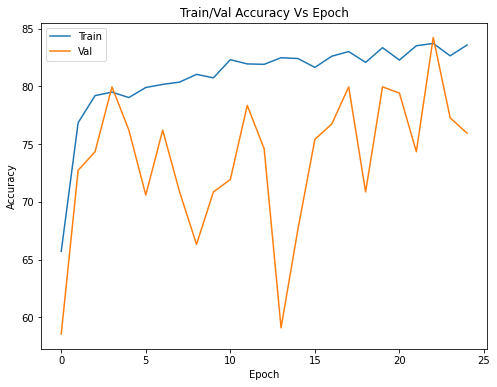

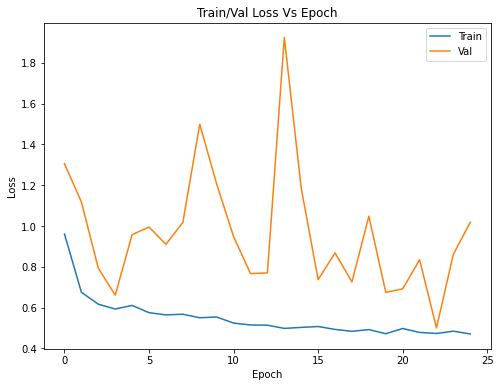

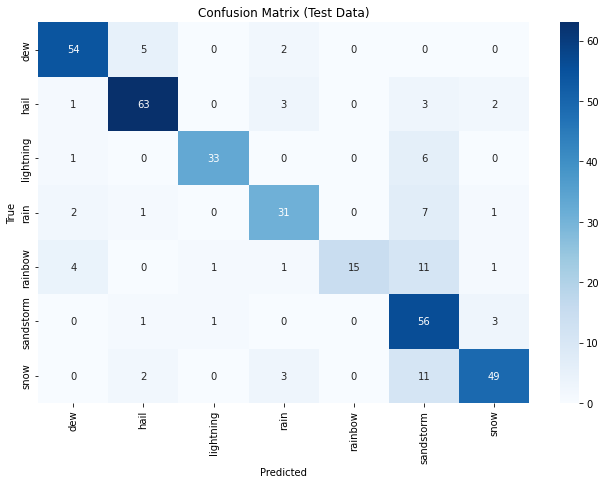

****************************************************************************************************


In [12]:
LABELS = ['dew', 'hail', 'lightning', 'rain', 'rainbow', 'sandstorm', 'snow']


train_loader, val_loader, test_loader = prepare_data(dataset_path='dataset', batch_size=8, resize_shape=(128, 128))


mobilenet_model = MobilenetTL(num_classes=7)
optimizer = optim.Adam(mobilenet_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.01, patience=5, verbose=True)


run_model(model=mobilenet_model, model_name='mobilenet_model', optim=optimizer, scheduler=scheduler, labels=LABELS,
              train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
              epochs=25, device='cuda', plot_graphs=True)

##### *Vgg16*

In [19]:
class VGG16TL(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.vgg16 = torchvision.models.vgg16(pretrained=True)
        self.fine_tune()
    

    def fine_tune(self):
        for param in self.vgg16.parameters():
            param.requires_grad = False
        
        self.vgg16.classifier = nn.Sequential(*[self.vgg16.classifier[i] for i in range(3)])
        self.vgg16.classifier.add_module('fc1', nn.Linear(in_features=4096, out_features=4096, bias=True))
        self.vgg16.classifier.add_module('relu1', nn.ReLU(inplace=True))
        self.vgg16.classifier.add_module('fc2', nn.Linear(in_features=4096, out_features=1024, bias=True))
        self.vgg16.classifier.add_module('relu2', nn.ReLU(inplace=True))
        self.vgg16.classifier.add_module('drpout', nn.Dropout(0.5))
        self.vgg16.classifier.add_module('fc3', nn.Linear(in_features=1024, out_features=128, bias=True))


    def forward(self, x):
        x = self.vgg16(x)
        return x

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 128, 128]           1,792
              ReLU-2          [8, 64, 128, 128]               0
            Conv2d-3          [8, 64, 128, 128]          36,928
              ReLU-4          [8, 64, 128, 128]               0
         MaxPool2d-5            [8, 64, 64, 64]               0
            Conv2d-6           [8, 128, 64, 64]          73,856
              ReLU-7           [8, 128, 64, 64]               0
            Conv2d-8           [8, 128, 64, 64]         147,584
              ReLU-9           [8, 128, 64, 64]               0
        MaxPool2d-10           [8, 128, 32, 32]               0
           Conv2d-11           [8, 256, 32, 32]         295,168
             ReLU-12           [8, 256, 32, 32]               0
           Conv2d-13           [8, 256, 32, 32]         590,080
             ReLU-14           [8, 256,

Total length of the dataset = 3737
Total classes of the dataset = ['dew', 'hail', 'lightning', 'rain', 'rainbow', 'sandstorm', 'snow']
80-10-10 split ratio count:
Train data = 2989 | Validation data = 374 | Test data = 374

Extracting mean and std...


100%|██████████| 374/374 [00:10<00:00, 35.30it/s]


Mean = tensor([0.4976, 0.4972, 0.4441]) | Std = tensor([0.1856, 0.1813, 0.1902])

Augmenting the data.

Returning train-val-test loaders.
DEVICE: cuda



Epoch 1/25: 100%|██████████| 374/374 [00:23<00:00, 15.70it/s]


train_loss = 0.8632 | val_loss = 0.6873 | train_acc = 72.6999% | val_acc = 78.6096%
val_acc improved -> saving model parameters to -> "vgg16_model_parameters.pt"


Epoch 2/25: 100%|██████████| 374/374 [00:21<00:00, 17.37it/s]


train_loss = 0.6392 | val_loss = 0.5923 | train_acc = 79.7257% | val_acc = 81.5508%
val_acc improved -> saving model parameters to -> "vgg16_model_parameters.pt"


Epoch 3/25: 100%|██████████| 374/374 [00:21<00:00, 17.06it/s]


train_loss = 0.6150 | val_loss = 0.5180 | train_acc = 80.9635% | val_acc = 84.2246%
val_acc improved -> saving model parameters to -> "vgg16_model_parameters.pt"


Epoch 4/25: 100%|██████████| 374/374 [00:22<00:00, 16.80it/s]


train_loss = 0.5533 | val_loss = 0.4466 | train_acc = 82.3018% | val_acc = 87.9679%
val_acc improved -> saving model parameters to -> "vgg16_model_parameters.pt"


Epoch 5/25: 100%|██████████| 374/374 [00:22<00:00, 16.68it/s]


train_loss = 0.5173 | val_loss = 0.5249 | train_acc = 83.2720% | val_acc = 85.5615%


Epoch 6/25: 100%|██████████| 374/374 [00:22<00:00, 16.51it/s]


train_loss = 0.5002 | val_loss = 0.6007 | train_acc = 84.5768% | val_acc = 85.0267%


Epoch 7/25: 100%|██████████| 374/374 [00:22<00:00, 16.36it/s]


train_loss = 0.5211 | val_loss = 0.4790 | train_acc = 83.4727% | val_acc = 85.2941%


Epoch 8/25: 100%|██████████| 374/374 [00:22<00:00, 16.37it/s]


train_loss = 0.4679 | val_loss = 0.6201 | train_acc = 85.2459% | val_acc = 81.5508%


Epoch 9/25: 100%|██████████| 374/374 [00:23<00:00, 16.24it/s]


train_loss = 0.4845 | val_loss = 0.4861 | train_acc = 84.4430% | val_acc = 86.0963%


Epoch 10/25: 100%|██████████| 374/374 [00:23<00:00, 16.13it/s]


train_loss = 0.4824 | val_loss = 1.1174 | train_acc = 84.2422% | val_acc = 79.1444%


Epoch 11/25: 100%|██████████| 374/374 [00:23<00:00, 16.03it/s]


train_loss = 0.4725 | val_loss = 0.6354 | train_acc = 84.6771% | val_acc = 85.5615%


Epoch 12/25: 100%|██████████| 374/374 [00:23<00:00, 16.00it/s]


train_loss = 0.4632 | val_loss = 0.3858 | train_acc = 85.3128% | val_acc = 85.8289%


Epoch 13/25: 100%|██████████| 374/374 [00:23<00:00, 16.02it/s]


train_loss = 0.4874 | val_loss = 0.4761 | train_acc = 85.6808% | val_acc = 87.4332%


Epoch 14/25: 100%|██████████| 374/374 [00:23<00:00, 16.01it/s]


train_loss = 0.4570 | val_loss = 0.3639 | train_acc = 85.7143% | val_acc = 88.5027%
val_acc improved -> saving model parameters to -> "vgg16_model_parameters.pt"


Epoch 15/25: 100%|██████████| 374/374 [00:23<00:00, 16.01it/s]


train_loss = 0.4819 | val_loss = 0.5057 | train_acc = 84.6771% | val_acc = 85.0267%


Epoch 16/25: 100%|██████████| 374/374 [00:23<00:00, 15.88it/s]


train_loss = 0.4691 | val_loss = 0.5863 | train_acc = 85.2794% | val_acc = 87.9679%


Epoch 17/25: 100%|██████████| 374/374 [00:23<00:00, 15.83it/s]


train_loss = 0.4669 | val_loss = 0.4980 | train_acc = 85.1790% | val_acc = 88.5027%
val_acc improved -> saving model parameters to -> "vgg16_model_parameters.pt"


Epoch 18/25: 100%|██████████| 374/374 [00:23<00:00, 15.90it/s]


train_loss = 0.4695 | val_loss = 0.8264 | train_acc = 85.4132% | val_acc = 83.9572%


Epoch 19/25: 100%|██████████| 374/374 [00:23<00:00, 15.81it/s]


train_loss = 0.4656 | val_loss = 0.3424 | train_acc = 84.9783% | val_acc = 87.4332%


Epoch 20/25: 100%|██████████| 374/374 [00:23<00:00, 15.75it/s]


Epoch    20: reducing learning rate of group 0 to 1.0000e-05.
train_loss = 0.4683 | val_loss = 0.3343 | train_acc = 85.8816% | val_acc = 89.0374%
val_acc improved -> saving model parameters to -> "vgg16_model_parameters.pt"


Epoch 21/25: 100%|██████████| 374/374 [00:23<00:00, 15.79it/s]


train_loss = 0.3916 | val_loss = 0.3203 | train_acc = 86.8518% | val_acc = 90.1070%
val_acc improved -> saving model parameters to -> "vgg16_model_parameters.pt"


Epoch 22/25: 100%|██████████| 374/374 [00:23<00:00, 15.80it/s]


train_loss = 0.3593 | val_loss = 0.3119 | train_acc = 87.8220% | val_acc = 90.1070%
val_acc improved -> saving model parameters to -> "vgg16_model_parameters.pt"


Epoch 23/25: 100%|██████████| 374/374 [00:23<00:00, 15.80it/s]


train_loss = 0.3515 | val_loss = 0.3104 | train_acc = 88.3573% | val_acc = 89.5722%


Epoch 24/25: 100%|██████████| 374/374 [00:23<00:00, 15.80it/s]


train_loss = 0.3690 | val_loss = 0.3079 | train_acc = 87.5878% | val_acc = 89.8396%


Epoch 25/25: 100%|██████████| 374/374 [00:23<00:00, 15.68it/s]


train_loss = 0.3582 | val_loss = 0.3103 | train_acc = 88.1566% | val_acc = 90.1070%
val_acc improved -> saving model parameters to -> "vgg16_model_parameters.pt"


****************************************************************************************************
Running the model on test set:

Loading the best model from -> "vgg16_model_parameters.pt"


47it [00:02, 16.18it/s]


Test acc = 90.909091%

Classification report:

              precision    recall  f1-score     support
dew            0.920635  0.935484  0.928000   62.000000
hail           0.967742  0.923077  0.944882   65.000000
lightning      0.947368  0.923077  0.935065   39.000000
rain           0.807692  0.913043  0.857143   46.000000
rainbow        0.900000  0.870968  0.885246   31.000000
sandstorm      0.932432  0.932432  0.932432   74.000000
snow           0.872727  0.842105  0.857143   57.000000
accuracy       0.909091  0.909091  0.909091    0.909091
macro avg      0.906942  0.905741  0.905702  374.000000
weighted avg   0.911041  0.909091  0.909490  374.000000


Graphs:



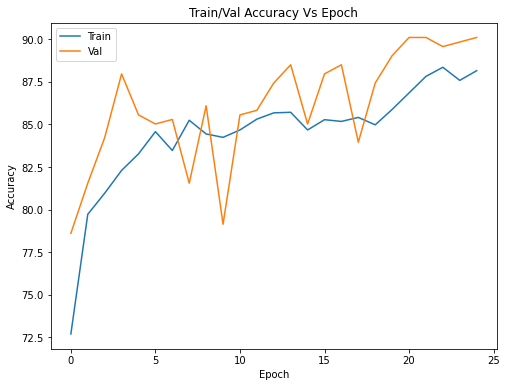

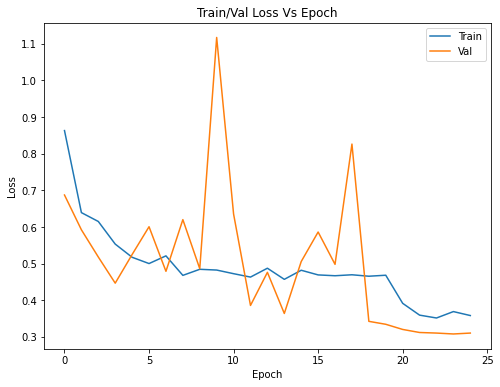

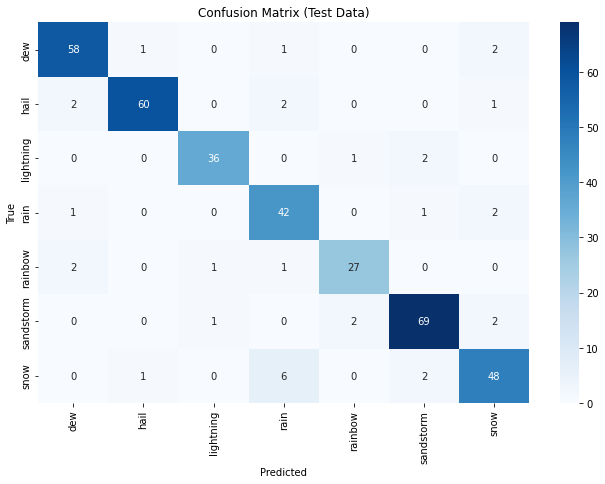

****************************************************************************************************


In [8]:
LABELS = ['dew', 'hail', 'lightning', 'rain', 'rainbow', 'sandstorm', 'snow']


train_loader, val_loader, test_loader = prepare_data(dataset_path='dataset', batch_size=8, resize_shape=(128, 128))


vgg16_model = VGG16TL(num_classes=7)
optimizer = optim.Adam(vgg16_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.01, patience=5, verbose=True)


run_model(model=vgg16_model, model_name='vgg16_model', optim=optimizer, scheduler=scheduler, labels=LABELS,
              train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
              epochs=25, device='cuda', plot_graphs=True)

##### *Resnet152*

In [17]:
class Resnet152TL(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.resnet152 = torchvision.models.resnet152(pretrained=True)
        self.fine_tune()
    

    def fine_tune(self):
        for param in self.resnet152.parameters():
            param.requires_grad = False
        
        self.resnet152.fc = nn.Sequential(
            nn.Linear(in_features=2048, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=self.num_classes)
        )
    

    def forward(self, x):
        x = self.resnet152(x)
        return x


summary(Resnet152TL(num_classes=7).cuda(), input_size=(3, 128, 128), batch_size=8, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [8, 64, 64, 64]           9,408
       BatchNorm2d-2            [8, 64, 64, 64]             128
              ReLU-3            [8, 64, 64, 64]               0
         MaxPool2d-4            [8, 64, 32, 32]               0
            Conv2d-5            [8, 64, 32, 32]           4,096
       BatchNorm2d-6            [8, 64, 32, 32]             128
              ReLU-7            [8, 64, 32, 32]               0
            Conv2d-8            [8, 64, 32, 32]          36,864
       BatchNorm2d-9            [8, 64, 32, 32]             128
             ReLU-10            [8, 64, 32, 32]               0
           Conv2d-11           [8, 256, 32, 32]          16,384
      BatchNorm2d-12           [8, 256, 32, 32]             512
           Conv2d-13           [8, 256, 32, 32]          16,384
      BatchNorm2d-14           [8, 256,

Total length of the dataset = 3737
Total classes of the dataset = ['dew', 'hail', 'lightning', 'rain', 'rainbow', 'sandstorm', 'snow']
80-10-10 split ratio count:
Train data = 2989 | Validation data = 374 | Test data = 374

Extracting mean and std...


100%|██████████| 374/374 [00:10<00:00, 35.98it/s]


Mean = tensor([0.5008, 0.4999, 0.4482]) | Std = tensor([0.1859, 0.1814, 0.1906])

Augmenting the data.

Returning train-val-test loaders.
DEVICE: cuda



Epoch 1/25: 100%|██████████| 374/374 [00:25<00:00, 14.79it/s]


train_loss = 0.8788 | val_loss = 6.6261 | train_acc = 69.3543% | val_acc = 67.1123%
val_acc improved -> saving model parameters to -> "resnet152_model_parameters.pt"


Epoch 2/25: 100%|██████████| 374/374 [00:25<00:00, 14.87it/s]


train_loss = 0.6675 | val_loss = 7.1985 | train_acc = 75.8782% | val_acc = 66.3102%


Epoch 3/25: 100%|██████████| 374/374 [00:25<00:00, 14.66it/s]


train_loss = 0.5859 | val_loss = 8.1761 | train_acc = 79.3911% | val_acc = 68.9840%
val_acc improved -> saving model parameters to -> "resnet152_model_parameters.pt"


Epoch 4/25: 100%|██████████| 374/374 [00:25<00:00, 14.53it/s]


train_loss = 0.5764 | val_loss = 11.0549 | train_acc = 79.9933% | val_acc = 69.2513%
val_acc improved -> saving model parameters to -> "resnet152_model_parameters.pt"


Epoch 5/25: 100%|██████████| 374/374 [00:26<00:00, 14.38it/s]


train_loss = 0.5427 | val_loss = 5.0774 | train_acc = 80.9970% | val_acc = 72.4599%
val_acc improved -> saving model parameters to -> "resnet152_model_parameters.pt"


Epoch 6/25: 100%|██████████| 374/374 [00:26<00:00, 14.24it/s]


train_loss = 0.5343 | val_loss = 6.0193 | train_acc = 81.2981% | val_acc = 71.1230%


Epoch 7/25: 100%|██████████| 374/374 [00:26<00:00, 14.15it/s]


train_loss = 0.5570 | val_loss = 11.0743 | train_acc = 80.6624% | val_acc = 66.8449%


Epoch 8/25: 100%|██████████| 374/374 [00:26<00:00, 14.08it/s]


train_loss = 0.4838 | val_loss = 15.2330 | train_acc = 83.2051% | val_acc = 68.4492%


Epoch 9/25: 100%|██████████| 374/374 [00:26<00:00, 14.06it/s]


train_loss = 0.4642 | val_loss = 3.2418 | train_acc = 83.9746% | val_acc = 72.4599%
val_acc improved -> saving model parameters to -> "resnet152_model_parameters.pt"


Epoch 10/25: 100%|██████████| 374/374 [00:26<00:00, 14.00it/s]


train_loss = 0.4833 | val_loss = 24.3776 | train_acc = 83.3724% | val_acc = 64.7059%


Epoch 11/25: 100%|██████████| 374/374 [00:26<00:00, 13.94it/s]


train_loss = 0.4549 | val_loss = 10.5578 | train_acc = 84.2088% | val_acc = 71.3904%


Epoch 12/25: 100%|██████████| 374/374 [00:26<00:00, 13.87it/s]


train_loss = 0.4727 | val_loss = 5.8043 | train_acc = 83.0713% | val_acc = 74.0642%
val_acc improved -> saving model parameters to -> "resnet152_model_parameters.pt"


Epoch 13/25: 100%|██████████| 374/374 [00:27<00:00, 13.83it/s]


train_loss = 0.4430 | val_loss = 12.5492 | train_acc = 84.4430% | val_acc = 63.3690%


Epoch 14/25: 100%|██████████| 374/374 [00:27<00:00, 13.74it/s]


train_loss = 0.4368 | val_loss = 19.6566 | train_acc = 84.4095% | val_acc = 66.3102%


Epoch 15/25: 100%|██████████| 374/374 [00:27<00:00, 13.72it/s]


train_loss = 0.4365 | val_loss = 5.1398 | train_acc = 83.6400% | val_acc = 73.7968%


Epoch 16/25: 100%|██████████| 374/374 [00:27<00:00, 13.72it/s]


train_loss = 0.4924 | val_loss = 3.3202 | train_acc = 82.5025% | val_acc = 78.3422%
val_acc improved -> saving model parameters to -> "resnet152_model_parameters.pt"


Epoch 17/25: 100%|██████████| 374/374 [00:27<00:00, 13.60it/s]


train_loss = 0.4292 | val_loss = 5.5593 | train_acc = 84.9113% | val_acc = 74.8663%


Epoch 18/25: 100%|██████████| 374/374 [00:27<00:00, 13.61it/s]


train_loss = 0.4215 | val_loss = 6.7211 | train_acc = 84.4430% | val_acc = 76.2032%


Epoch 19/25: 100%|██████████| 374/374 [00:27<00:00, 13.66it/s]


train_loss = 0.4206 | val_loss = 10.2066 | train_acc = 85.2459% | val_acc = 73.7968%


Epoch 20/25: 100%|██████████| 374/374 [00:27<00:00, 13.67it/s]


train_loss = 0.4306 | val_loss = 4.9429 | train_acc = 84.8779% | val_acc = 72.9947%


Epoch 21/25: 100%|██████████| 374/374 [00:27<00:00, 13.65it/s]


train_loss = 0.3897 | val_loss = 4.3244 | train_acc = 85.9485% | val_acc = 78.0749%


Epoch 22/25: 100%|██████████| 374/374 [00:27<00:00, 13.60it/s]


train_loss = 0.3929 | val_loss = 7.9825 | train_acc = 86.1158% | val_acc = 72.7273%


Epoch 23/25: 100%|██████████| 374/374 [00:27<00:00, 13.57it/s]


train_loss = 0.4220 | val_loss = 9.6854 | train_acc = 84.8779% | val_acc = 72.1925%


Epoch 24/25: 100%|██████████| 374/374 [00:27<00:00, 13.57it/s]


train_loss = 0.3875 | val_loss = 14.5691 | train_acc = 86.3165% | val_acc = 70.3209%


Epoch 25/25: 100%|██████████| 374/374 [00:27<00:00, 13.39it/s]


train_loss = 0.4015 | val_loss = 8.7133 | train_acc = 85.5470% | val_acc = 71.9251%


****************************************************************************************************
Running the model on test set:

Loading the best model from -> "resnet152_model_parameters.pt"


47it [00:02, 15.68it/s]

Test acc = 72.727273%

Classification report:

              precision    recall  f1-score     support
dew            0.507692  0.942857  0.660000   70.000000
hail           0.784615  0.910714  0.842975   56.000000
lightning      1.000000  0.384615  0.555556   39.000000
rain           0.888889  0.827586  0.857143   58.000000
rainbow        0.894737  0.653846  0.755556   26.000000
sandstorm      0.762712  0.642857  0.697674   70.000000
snow           0.937500  0.545455  0.689655   55.000000
accuracy       0.727273  0.727273  0.727273    0.727273
macro avg      0.825164  0.701133  0.722651  374.000000
weighted avg   0.797454  0.727273  0.725134  374.000000


Graphs:



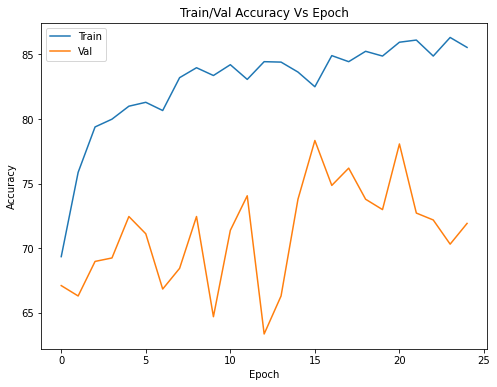

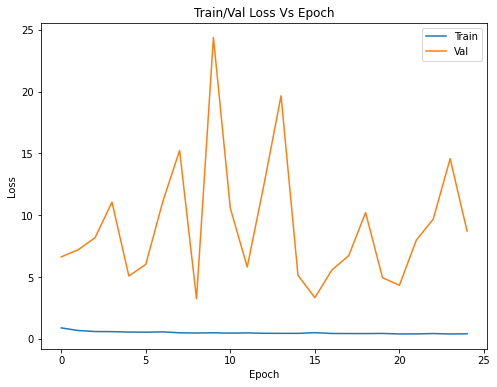

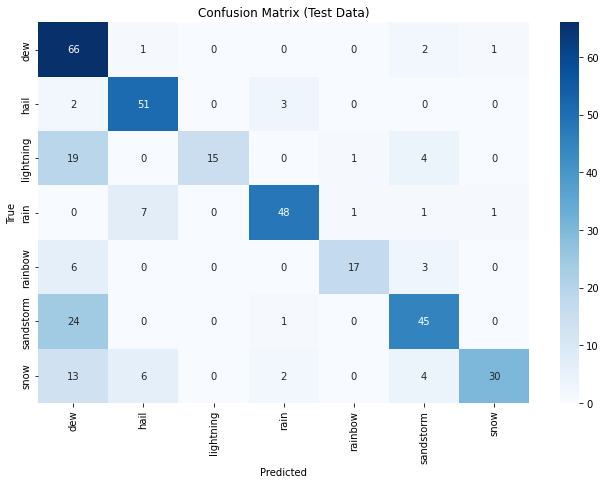

****************************************************************************************************


In [10]:
LABELS = ['dew', 'hail', 'lightning', 'rain', 'rainbow', 'sandstorm', 'snow']


train_loader, val_loader, test_loader = prepare_data(dataset_path='dataset', batch_size=8, resize_shape=(128, 128))


resnet152_model = Resnet152TL(num_classes=7)
optimizer = optim.Adam(resnet152_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.01, patience=5, verbose=True)


run_model(model=resnet152_model, model_name='resnet152_model', optim=optimizer, scheduler=scheduler, labels=LABELS,
              train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
              epochs=25, device='cuda', plot_graphs=True)

##### *Vision transformer (VIT)*

In [18]:
class VITTL(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.vit = ViT('B_16', pretrained=True)
        self.fine_tune()
    
    def fine_tune(self):
        for param in self.vit.parameters():
            param.requires_grad = False

        self.vit.fc = nn.Sequential(
            nn.Linear(in_features=768, out_features=self.num_classes), 
        )
    

    def forward(self, x):
        x = self.vit(x)
        return x


summary(VITTL(num_classes=7).cuda(), input_size=(3, 224, 224), batch_size=8, device='cuda')

Loaded pretrained weights.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [8, 768, 14, 14]         590,592
PositionalEmbedding1D-2              [8, 197, 768]               0
         LayerNorm-3              [8, 197, 768]           1,536
            Linear-4              [8, 197, 768]         590,592
            Linear-5              [8, 197, 768]         590,592
            Linear-6              [8, 197, 768]         590,592
           Dropout-7          [8, 12, 197, 197]               0
MultiHeadedSelfAttention-8              [8, 197, 768]               0
            Linear-9              [8, 197, 768]         590,592
          Dropout-10              [8, 197, 768]               0
        LayerNorm-11              [8, 197, 768]           1,536
           Linear-12             [8, 197, 3072]       2,362,368
           Linear-13              [8, 197, 768]       2,360,064
Pos

Total length of the dataset = 3737
Total classes of the dataset = ['dew', 'hail', 'lightning', 'rain', 'rainbow', 'sandstorm', 'snow']
80-10-10 split ratio count:
Train data = 2989 | Validation data = 374 | Test data = 374

Extracting mean and std...


100%|██████████| 374/374 [00:13<00:00, 28.18it/s]


Mean = tensor([0.4973, 0.4977, 0.4456]) | Std = tensor([0.1892, 0.1849, 0.1937])

Augmenting the data.

Returning train-val-test loaders.
Loaded pretrained weights.
DEVICE: cuda



Epoch 1/25: 100%|██████████| 374/374 [00:58<00:00,  6.43it/s]


train_loss = 0.8066 | val_loss = 0.4291 | train_acc = 82.8371% | val_acc = 94.1176%
val_acc improved -> saving model parameters to -> "vit_model_parameters.pt"


Epoch 2/25: 100%|██████████| 374/374 [00:56<00:00,  6.58it/s]


train_loss = 0.3679 | val_loss = 0.2946 | train_acc = 90.1305% | val_acc = 94.9198%
val_acc improved -> saving model parameters to -> "vit_model_parameters.pt"


Epoch 3/25: 100%|██████████| 374/374 [00:56<00:00,  6.66it/s]


train_loss = 0.2791 | val_loss = 0.2360 | train_acc = 92.3386% | val_acc = 95.4545%
val_acc improved -> saving model parameters to -> "vit_model_parameters.pt"


Epoch 4/25: 100%|██████████| 374/374 [00:57<00:00,  6.50it/s]


train_loss = 0.2434 | val_loss = 0.2201 | train_acc = 93.0746% | val_acc = 95.1872%


Epoch 5/25: 100%|██████████| 374/374 [00:57<00:00,  6.51it/s]


train_loss = 0.2247 | val_loss = 0.1969 | train_acc = 92.9742% | val_acc = 95.4545%
val_acc improved -> saving model parameters to -> "vit_model_parameters.pt"


Epoch 6/25: 100%|██████████| 374/374 [00:57<00:00,  6.50it/s]


train_loss = 0.2053 | val_loss = 0.1939 | train_acc = 93.3088% | val_acc = 95.4545%
val_acc improved -> saving model parameters to -> "vit_model_parameters.pt"


Epoch 7/25: 100%|██████████| 374/374 [00:57<00:00,  6.49it/s]


train_loss = 0.1941 | val_loss = 0.1831 | train_acc = 93.7103% | val_acc = 96.2567%
val_acc improved -> saving model parameters to -> "vit_model_parameters.pt"


Epoch 8/25: 100%|██████████| 374/374 [00:57<00:00,  6.45it/s]


train_loss = 0.1774 | val_loss = 0.1776 | train_acc = 94.9147% | val_acc = 95.7219%


Epoch 9/25: 100%|██████████| 374/374 [00:58<00:00,  6.42it/s]


train_loss = 0.1605 | val_loss = 0.1771 | train_acc = 95.1823% | val_acc = 95.4545%


Epoch 10/25: 100%|██████████| 374/374 [00:58<00:00,  6.41it/s]


train_loss = 0.1579 | val_loss = 0.1845 | train_acc = 95.1154% | val_acc = 95.7219%


Epoch 11/25: 100%|██████████| 374/374 [00:58<00:00,  6.39it/s]


train_loss = 0.1525 | val_loss = 0.1751 | train_acc = 95.2492% | val_acc = 95.4545%


Epoch 12/25: 100%|██████████| 374/374 [00:58<00:00,  6.37it/s]


train_loss = 0.1487 | val_loss = 0.1731 | train_acc = 95.3831% | val_acc = 95.4545%


Epoch 13/25: 100%|██████████| 374/374 [00:58<00:00,  6.35it/s]


train_loss = 0.1504 | val_loss = 0.1756 | train_acc = 95.6173% | val_acc = 95.4545%


Epoch 14/25: 100%|██████████| 374/374 [00:59<00:00,  6.33it/s]


train_loss = 0.1421 | val_loss = 0.1778 | train_acc = 95.2492% | val_acc = 95.7219%


Epoch 15/25: 100%|██████████| 374/374 [00:59<00:00,  6.32it/s]


train_loss = 0.1360 | val_loss = 0.1744 | train_acc = 96.1191% | val_acc = 95.4545%


Epoch 16/25: 100%|██████████| 374/374 [00:59<00:00,  6.33it/s]


train_loss = 0.1360 | val_loss = 0.1675 | train_acc = 95.7176% | val_acc = 95.7219%


Epoch 17/25: 100%|██████████| 374/374 [00:59<00:00,  6.32it/s]


train_loss = 0.1326 | val_loss = 0.1754 | train_acc = 95.8180% | val_acc = 95.4545%


Epoch 18/25: 100%|██████████| 374/374 [00:59<00:00,  6.30it/s]


train_loss = 0.1296 | val_loss = 0.1706 | train_acc = 95.4165% | val_acc = 95.4545%


Epoch 19/25: 100%|██████████| 374/374 [00:59<00:00,  6.29it/s]


train_loss = 0.1204 | val_loss = 0.1648 | train_acc = 96.3533% | val_acc = 95.4545%


Epoch 20/25: 100%|██████████| 374/374 [00:59<00:00,  6.32it/s]


train_loss = 0.1337 | val_loss = 0.1776 | train_acc = 95.4165% | val_acc = 95.7219%


Epoch 21/25: 100%|██████████| 374/374 [00:59<00:00,  6.32it/s]


train_loss = 0.1200 | val_loss = 0.1641 | train_acc = 96.6209% | val_acc = 95.4545%


Epoch 22/25: 100%|██████████| 374/374 [00:59<00:00,  6.30it/s]


train_loss = 0.1285 | val_loss = 0.1611 | train_acc = 95.9518% | val_acc = 95.7219%


Epoch 23/25: 100%|██████████| 374/374 [00:59<00:00,  6.30it/s]


train_loss = 0.1212 | val_loss = 0.1642 | train_acc = 96.3868% | val_acc = 95.7219%


Epoch 24/25: 100%|██████████| 374/374 [00:59<00:00,  6.30it/s]


train_loss = 0.1135 | val_loss = 0.1647 | train_acc = 96.3198% | val_acc = 95.7219%


Epoch 25/25: 100%|██████████| 374/374 [00:59<00:00,  6.30it/s]


train_loss = 0.1111 | val_loss = 0.1608 | train_acc = 96.6209% | val_acc = 95.7219%


****************************************************************************************************
Running the model on test set:

Loading the best model from -> "vit_model_parameters.pt"


47it [00:07,  6.34it/s]


Test acc = 97.860963%

Classification report:

              precision    recall  f1-score    support
dew            0.985507  0.971429  0.978417   70.00000
hail           0.967213  0.967213  0.967213   61.00000
lightning      0.977273  1.000000  0.988506   43.00000
rain           0.964912  0.982143  0.973451   56.00000
rainbow        0.941176  1.000000  0.969697   16.00000
sandstorm      1.000000  0.971429  0.985507   70.00000
snow           0.982759  0.982759  0.982759   58.00000
accuracy       0.978610  0.978610  0.978610    0.97861
macro avg      0.974120  0.982139  0.977936  374.00000
weighted avg   0.978883  0.978610  0.978633  374.00000


Graphs:



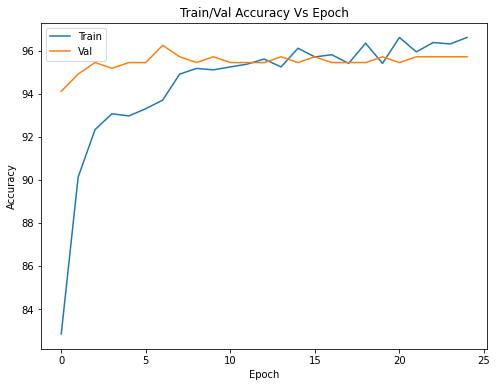

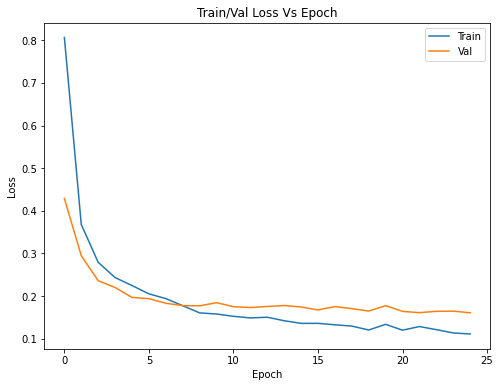

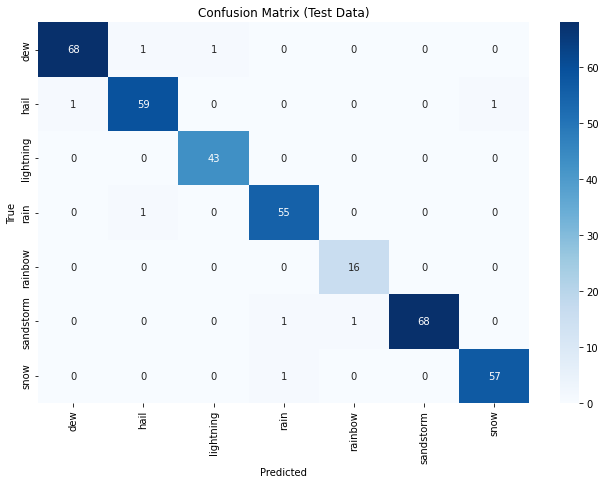

****************************************************************************************************


In [10]:
LABELS = ['dew', 'hail', 'lightning', 'rain', 'rainbow', 'sandstorm', 'snow']


train_loader, val_loader, test_loader = prepare_data(dataset_path='dataset', batch_size=8, resize_shape=(224, 224))


vit_model = VITTL(num_classes=7)
optimizer = optim.Adam(vit_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.01, patience=5, verbose=True)


run_model(model=vit_model, model_name='vit_model', optim=optimizer, scheduler=scheduler, labels=LABELS,
              train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
              epochs=25, device='cuda', plot_graphs=True)

Testing on a random image

In [2]:
class VITTL(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.vit = ViT('B_16', pretrained=True)
        self.fine_tune()
    
    def fine_tune(self):
        for param in self.vit.parameters():
            param.requires_grad = False

        self.vit.fc = nn.Sequential(
            nn.Linear(in_features=768, out_features=self.num_classes), 
        )
    

    def forward(self, x):
        x = self.vit(x)
        return x


model = VITTL(num_classes=7)
model.load_state_dict(torch.load('vit_model_parameters.pt'))

Loaded pretrained weights.


<All keys matched successfully>

Actual class is Hail



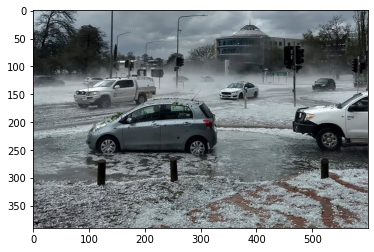


Predicted class is Snow


In [3]:
encoding = {
    0: 'Dew',
    1: 'Hail',
    2: 'Lightning',
    3: 'Rain',
    4: 'Rainbow',
    5: 'Sandstorm',
    6: 'Snow'
}

actual_class = 'Hail'
print(f'Actual class is {actual_class}\n')
im=Image.open('hail test.jpg')
im = np.array(im)
plt.imshow(im)
plt.show()
print()

tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4973, 0.4977, 0.4456], std=[0.1892, 0.1849, 0.1937])
    ])

im = tf(im).unsqueeze(0)
ypred = model(im)
_, predicted = torch.max(ypred, 1)
predicted_image = encoding[predicted.item()]
print(f'Predicted class is {predicted_image}')

Here we can say that our model's weakness i.e. hail and snow confusion (evident from confusion matrix).

##### *Vision transformer (11 classes) - Just a fun test to check the strength of ViT*
We did not consider 11 classes as it was not relevant to our problem statement. However, we still tried this model for 11 classes just to check how well it does.

In [28]:
class VGG16TL(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.vgg16 = torchvision.models.vgg16(pretrained=True)
        self.fine_tune()
    

    def fine_tune(self):
        for param in self.vgg16.parameters():
            param.requires_grad = False
        
        self.vgg16.classifier = nn.Sequential(*[self.vgg16.classifier[i] for i in range(3)])
        self.vgg16.classifier.add_module('fc1', nn.Linear(in_features=4096, out_features=4096, bias=True))
        self.vgg16.classifier.add_module('relu1', nn.ReLU(inplace=True))
        self.vgg16.classifier.add_module('fc2', nn.Linear(in_features=4096, out_features=1024, bias=True))
        self.vgg16.classifier.add_module('relu2', nn.ReLU(inplace=True))
        self.vgg16.classifier.add_module('drpout', nn.Dropout(0.5))
        self.vgg16.classifier.add_module('fc3', nn.Linear(in_features=1024, out_features=128, bias=True))


    def forward(self, x):
        x = self.vgg16(x)
        return x


class VITTL(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()
        self.num_classes = num_classes

        self.vit = ViT('B_16', pretrained=True)
        self.vit2 = ViT('B_16', pretrained=True)

        self.fine_tune()
    

    def fine_tune(self):
        for param in self.vit.parameters():
            param.requires_grad = False

        self.vit.fc = nn.Sequential(
            nn.Linear(in_features=768, out_features=128), 
        )

        self.vit2.fc = nn.Sequential(
            nn.Linear(in_features=224*224, out_features=self.num_classes), 
        )

    def forward(self, x):
        output_branch1 = self.vit(x)
        output_branch1 = output_branch1.view(-1, 64, 2, 1)
        
        output_from_vit = transforms.Resize((224, 224, 3))(output_branch1)
        print(output_from_vit.size())
        output = self.vit2(output_from_vit)

       
        
        return output

In [7]:
train_loader, val_loader, test_loader = prepare_data(dataset_path='dataset', batch_size=8, resize_shape=(224, 224))

Total length of the dataset = 6862
Total classes of the dataset = ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
80-10-10 split ratio count:
Train data = 5489 | Validation data = 686 | Test data = 687

Extracting mean and std...


100%|██████████| 687/687 [00:27<00:00, 24.61it/s]

Mean = tensor([0.5173, 0.5252, 0.5055]) | Std = tensor([0.1904, 0.1841, 0.1908])

Augmenting the data.

Returning train-val-test loaders.


Total length of the dataset = 6862
Total classes of the dataset = ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
80-10-10 split ratio count:
Train data = 5489 | Validation data = 686 | Test data = 687

Extracting mean and std...


100%|██████████| 687/687 [00:24<00:00, 27.90it/s]


Mean = tensor([0.5178, 0.5257, 0.5056]) | Std = tensor([0.1902, 0.1839, 0.1904])

Augmenting the data.

Returning train-val-test loaders.
Loaded pretrained weights.
DEVICE: cuda



Epoch 1/5: 100%|██████████| 687/687 [02:25<00:00,  4.71it/s]


train_loss = 0.8676 | val_loss = 0.6088 | train_acc = 70.0128% | val_acc = 79.5918%
val_acc improved -> saving model parameters to -> "vit_model_11_classes_parameters.pt"


Epoch 2/5: 100%|██████████| 687/687 [02:31<00:00,  4.53it/s]


train_loss = 0.5084 | val_loss = 0.4812 | train_acc = 82.8566% | val_acc = 84.6939%
val_acc improved -> saving model parameters to -> "vit_model_11_classes_parameters.pt"


Epoch 3/5: 100%|██████████| 687/687 [02:29<00:00,  4.60it/s]


train_loss = 0.4296 | val_loss = 0.4439 | train_acc = 85.2068% | val_acc = 85.4227%
val_acc improved -> saving model parameters to -> "vit_model_11_classes_parameters.pt"


Epoch 4/5: 100%|██████████| 687/687 [02:31<00:00,  4.55it/s]


train_loss = 0.3769 | val_loss = 0.5602 | train_acc = 86.9375% | val_acc = 81.0496%


Epoch 5/5: 100%|██████████| 687/687 [02:31<00:00,  4.53it/s]


train_loss = 0.3630 | val_loss = 0.5160 | train_acc = 88.0488% | val_acc = 82.2157%


****************************************************************************************************
Running the model on test set:

Loading the best model from -> "vit_model_11_classes_parameters.pt"


86it [00:18,  4.64it/s]

Test acc = 85.735080%

Classification report:

              precision    recall  f1-score     support
dew            0.985075  0.970588  0.977778   68.000000
fogsmog        0.935897  0.829545  0.879518   88.000000
frost          0.822222  0.755102  0.787234   49.000000
glaze          0.607595  0.827586  0.700730   58.000000
hail           0.885246  0.947368  0.915254   57.000000
lightning      0.977273  1.000000  0.988506   43.000000
rain           0.937500  0.833333  0.882353   54.000000
rainbow        0.857143  1.000000  0.923077   18.000000
rime           0.848739  0.821138  0.834711  123.000000
sandstorm      0.887097  0.964912  0.924370   57.000000
snow           0.777778  0.680556  0.725926   72.000000
accuracy       0.857351  0.857351  0.857351    0.857351
macro avg      0.865597  0.875466  0.867223  687.000000
weighted avg   0.865165  0.857351  0.858320  687.000000


Graphs:



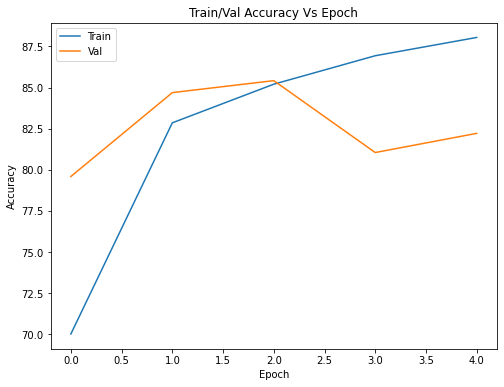

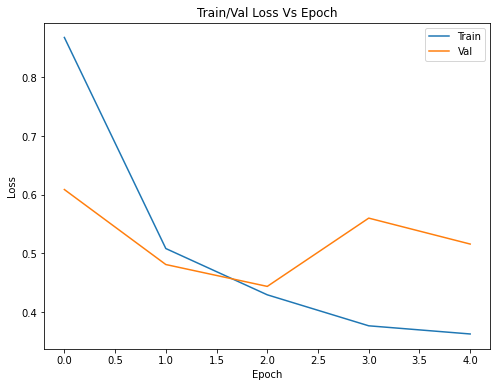

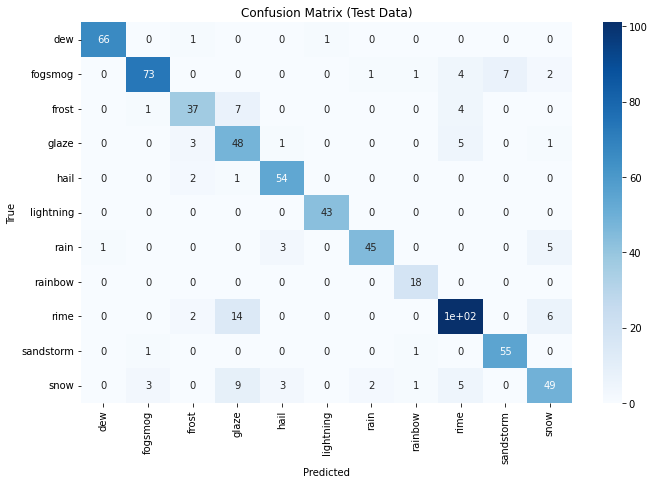

****************************************************************************************************


In [21]:
LABELS = ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


train_loader, val_loader, test_loader = prepare_data(dataset_path='dataset', batch_size=8, resize_shape=(224, 224))


vit_model = VITTL(num_classes=11)
optimizer = optim.Adam(vit_model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.01, patience=5, verbose=True)


run_model(model=vit_model, model_name='vit_model_11_classes', optim=optimizer, scheduler=scheduler, labels=LABELS,
              train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
              epochs=5, device='cuda', plot_graphs=True)

#### ViT and DeepViT Fusion


In [22]:
class VitDeepVitFusion(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.vit = ViT(
                        image_size = 224,
                        patch_size = 16,
                        num_classes = 11,
                        dim = 1024,
                        depth = 6,
                        heads = 16,
                        mlp_dim = 2048,
                        dropout = 0.1,
                        emb_dropout = 0.1
        )

        self.vit.mlp_head[1] = nn.Linear(in_features=1024, out_features=256)
        
        self.deepvit = DeepViT(image_size = 224,
                            patch_size = 32,
                            num_classes = 11,
                            dim = 1024,
                            depth = 6,
                            heads = 16,
                            mlp_dim = 2048,
                            dropout = 0.1,
                            emb_dropout = 0.1
        )

        self.deepvit.mlp_head[1] = nn.Linear(in_features=1024, out_features=256)

        self.linear = nn.Linear(in_features=512, out_features=11)


    def forward(self, x):
        output_vit = self.vit(x)
        output_deepvit = self.deepvit(x)

        concat_output = torch.cat([output_vit, output_deepvit], dim=1)
        output = self.linear(concat_output)
        return output

Total length of the dataset = 6862
Total classes of the dataset = ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
80-10-10 split ratio count:
Train data = 5489 | Validation data = 686 | Test data = 687

Extracting mean and std...


100%|██████████| 687/687 [00:25<00:00, 26.58it/s]


Mean = tensor([0.5169, 0.5257, 0.5073]) | Std = tensor([0.1895, 0.1836, 0.1903])

Augmenting the data.

Returning train-val-test loaders.
DEVICE: cuda



Epoch 1/5: 100%|██████████| 687/687 [03:07<00:00,  3.66it/s]


train_loss = 1.6718 | val_loss = 1.5095 | train_acc = 43.5963% | val_acc = 49.2711%
val_acc improved -> saving model parameters to -> "vit_fusion_11_classes_parameters.pt"


Epoch 2/5: 100%|██████████| 687/687 [03:06<00:00,  3.69it/s]


train_loss = 1.2850 | val_loss = 1.2393 | train_acc = 55.2742% | val_acc = 57.4344%
val_acc improved -> saving model parameters to -> "vit_fusion_11_classes_parameters.pt"


Epoch 3/5: 100%|██████████| 687/687 [03:07<00:00,  3.66it/s]


train_loss = 1.1835 | val_loss = 1.2668 | train_acc = 59.1547% | val_acc = 54.8105%


Epoch 4/5: 100%|██████████| 687/687 [03:08<00:00,  3.64it/s]


train_loss = 1.1445 | val_loss = 1.1049 | train_acc = 60.0109% | val_acc = 60.6414%
val_acc improved -> saving model parameters to -> "vit_fusion_11_classes_parameters.pt"


Epoch 5/5: 100%|██████████| 687/687 [03:08<00:00,  3.64it/s]


train_loss = 1.1128 | val_loss = 1.1077 | train_acc = 61.1587% | val_acc = 63.2653%
val_acc improved -> saving model parameters to -> "vit_fusion_11_classes_parameters.pt"


****************************************************************************************************
Running the model on test set:

Loading the best model from -> "vit_fusion_11_classes_parameters.pt"


86it [00:11,  7.19it/s]


Test acc = 61.135371%

Classification report:

              precision    recall  f1-score     support
dew            0.843373  0.786517  0.813953   89.000000
fogsmog        0.789474  0.666667  0.722892   90.000000
frost          0.428571  0.133333  0.203390   45.000000
glaze          0.273585  0.630435  0.381579   46.000000
hail           0.727273  0.275862  0.400000   58.000000
lightning      0.850000  0.772727  0.809524   44.000000
rain           0.640000  0.355556  0.457143   45.000000
rainbow        0.410256  0.592593  0.484848   27.000000
rime           0.554348  0.935780  0.696246  109.000000
sandstorm      0.854839  0.746479  0.796992   71.000000
snow           0.500000  0.285714  0.363636   63.000000
accuracy       0.611354  0.611354  0.611354    0.611354
macro avg      0.624702  0.561969  0.557291  687.000000
weighted avg   0.655109  0.611354  0.599818  687.000000


Graphs:



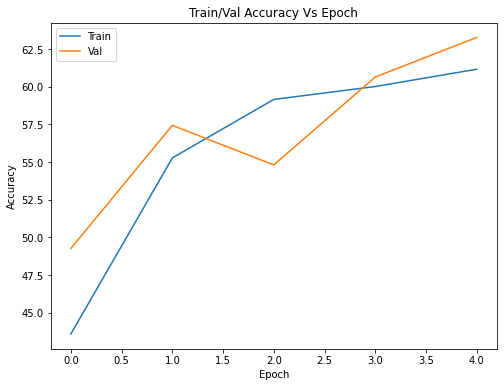

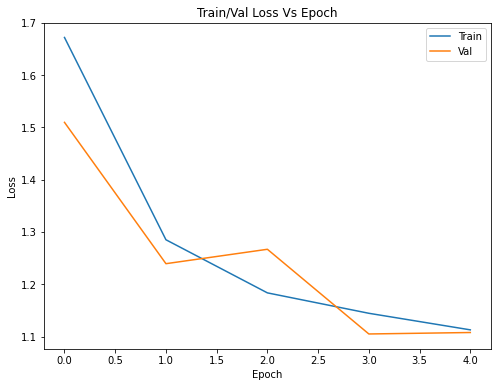

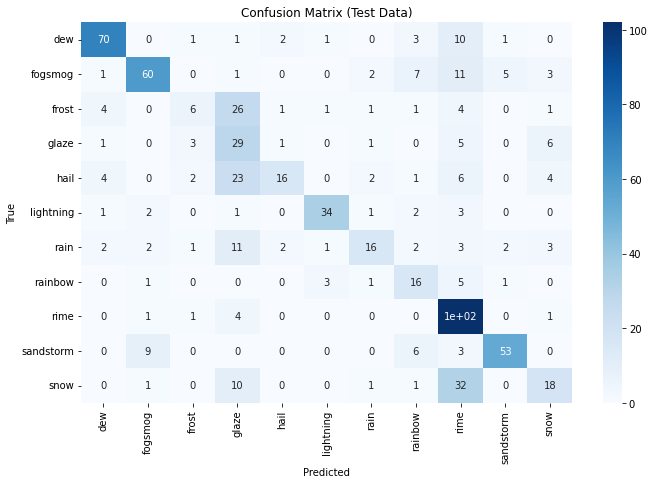

****************************************************************************************************


In [18]:
LABELS = ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


train_loader, val_loader, test_loader = prepare_data(dataset_path='dataset', batch_size=8, resize_shape=(224, 224))


vit_model = VitDeepVitFusion()
optimizer = optim.Adam(vit_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.01, patience=5, verbose=True)


run_model(model=vit_model, model_name='vit_fusion_11_classes', optim=optimizer, scheduler=scheduler, labels=LABELS,
              train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
              epochs=25, device='cuda', plot_graphs=True)

In [ ]:
img = torch.randn(1, 3, 224, 224)
pred = VitDeepVitFusion()(img)
pred.size()